In [2]:
#install Required Packages if not exists: umap-learn hdbscan torch transformers sentence-transformers gensim wordcloud pyspellchecker contractions deep-translator langdetect openpyxl

import numpy as np
import pandas as pd
import re
import json
from datetime import datetime
from typing import List, Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Advanced ML Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity
import umap.umap_ as umap
import hdbscan

# Deep Learning Libraries
import torch
from transformers import (
    AutoTokenizer, 
    AutoModel, 
    AutoModelForSequenceClassification,
    pipeline
)
from sentence_transformers import SentenceTransformer
import gensim
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.phrases import Phrases, Phraser

# Visualization Techni
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [3]:
# Load Excel file (Install openpyxl for loading (!pip install openpyxl))
df = pd.read_excel("D:\\IndiaAI\\Champions Code\\Dataset\\Champion_Data.xlsx")
df[['Gims_CategoryName','GrievanceDescription', 'FinalReply']].head(15)
#df.shape

,Gims_CategoryName,GrievanceDescription,FinalReply
0,UAM/Udyam Registration/Certificate related issues,Please find the attachment of Letter Head,"Sir,&#13;&#10; Please upload the clear im..."
1,UAM/Udyam Registration/Certificate related issues,Udyam no Udyam-br-31-0038425 My address i...,"Sir,&#13;&#10;As per your request you are advi..."
2,UAM/Udyam Registration/Certificate related issues,"To, The Udyog Aadhaar Registration Authority,...",&#2350;&#2361;&#2379;&#2342;&#2351;/&#2350;&#2...
3,UAM/Udyam Registration/Certificate related issues,"This is regarding Udyam Registration, even aft...",With the provided PAN the registered Udyam is ...
4,UAM/Udyam Registration/Certificate related issues,The grievance is regarding my Udyam Registrati...,With the provided PAN the registered Udyam is ...
5,UAM/Udyam Registration/Certificate related issues,"DEAR SIR, I AM A PROPRIETOR HAVING PAN: GZDPD7...","Madam,&#13;&#10;This is regarding your grievan..."
6,UAM/Udyam Registration/Certificate related issues,When I apply for udyam registration.. It shows...,"Sir, the following information is available in..."
7,UAM/Udyam Registration/Certificate related issues,सर / मैडम मैं सुभम अग्रवाल पुत्र फते चन्द्र ...,"Sir,&#13;&#10; As per our records an UAM is re..."
8,UAM/Udyam Registration/Certificate related issues,I am running a Cement Business and want to get...,Your Udyam registration Number is UDYAM-RJ-17...
9,Related to DCMSME Scheme,Sir mera pm vishwakarma yojna ka OTP nhi aa rh...,The Tool kit will be distributed through India...


In [4]:
# Print categories in Gims_CategoryName column and their counts
df['Gims_CategoryName'].value_counts()

Gims_CategoryName
UAM/Udyam Registration/Certificate related issues                    7663
Delayed Payment/MSEFC related issues                                  524
Loans from Banks                                                      194
Related to Scheme of KVIC                                             105
Related to MSME Scheme                                                 89
Related to  MSME-DFO                                                   72
MSME Act 2006 related Matters                                          48
Any other banking issue                                                42
Related to Public Procurement by PSUs                                  28
Related to DCMSME Scheme                                               28
Related to GST                                                         25
Related to various State Government                                    24
Insurance Claim related issues                                         16
Definition of MSMEs 

In [5]:
# Translating GrievanceDescription & FinalReply to English (Hindi/Hinglish/other → English) including lowercasing
# Uses existing libraries: deep-translator (GoogleTranslator) + langdetect for language detection.
# Note: Translation requires internet access and may be rate-limited by the provider.
# Install langauge detection and translation libraries if not already installed:(!pip install deep-translator langdetect)
import re
from functools import lru_cache
from deep_translator import GoogleTranslator
from langdetect import detect, LangDetectException
# Column names
CATEGORY_COL = "Gims_CategoryName"
DESC_COL = "GrievanceDescription"
REPLY_COL = "FinalReply"

# Quick script detection for Hindi (Devanagari block)
DEVANAGARI_RE = re.compile(r"[\u0900-\u097F]")

def _safe_str(x) -> str:
    if x is None or (isinstance(x, float) and pd.isna(x)) or pd.isna(x):
        return ""
    return str(x)

@lru_cache(maxsize=50000)
def _translate_cached(text: str) -> str:
    # GoogleTranslator auto-detects source when source='auto'
    return GoogleTranslator(source="auto", target="en").translate(text)

def to_english(text: str) -> str:
    text = _safe_str(text).strip()
    if not text:
        return ""
    # If the text contains Hindi characters, translate.
    if DEVANAGARI_RE.search(text):
        try:
            return _translate_cached(text)
        except Exception:
            return text
    # Otherwise, detect language; translate if not English.
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    if lang and lang != "en" and lang != "unknown":
        try:
            return _translate_cached(text)
        except Exception:
            return text
    # Hinglish may be detected as 'en' sometimes; you can force-translate later if needed.
    return text

# Defensive checks
missing_cols = [c for c in [DESC_COL, REPLY_COL] if c not in df.columns]
if missing_cols:
    raise KeyError(f"Missing expected columns in df: {missing_cols}. Available columns: {list(df.columns)}")

# Translate into English columns
df[CATEGORY_COL] = df[CATEGORY_COL].apply(to_english)
df[DESC_COL] = df[DESC_COL].apply(to_english)
df[REPLY_COL] = df[REPLY_COL].apply(to_english)

# Optional: standardize to lowercase after translation (English output)

df[CATEGORY_COL] = df[CATEGORY_COL].str.lower()
df[DESC_COL] = df[DESC_COL].str.lower()
df[REPLY_COL] = df[REPLY_COL].str.lower()

# Preview
df[[CATEGORY_COL, DESC_COL, REPLY_COL]].head(10)

,Gims_CategoryName,GrievanceDescription,FinalReply
0,uam/udyam registration/certificate related issues,please find the attachment of letter head,"sir,&#13;&#10; please upload the clear im..."
1,uam/udyam registration/certificate related issues,udyam no udyam-br-31-0038425 my address i...,"sir,&#13;&#10;as per your request you are advi..."
2,uam/udyam registration/certificate related issues,"to, the udyog aadhaar registration authority,...",&#2350;&#2361;&#2379;&#2342;&#2351;/&#2350;&#2...
3,uam/udyam registration/certificate related issues,"this is regarding udyam registration, even aft...",with the provided pan the registered udyam is ...
4,uam/udyam registration/certificate related issues,the grievance is regarding my udyam registrati...,with the provided pan the registered udyam is ...
5,uam/udyam registration/certificate related issues,"dear sir, i am a proprietor having pan: gzdpd7...","madam,&#13;&#10;this is regarding your grievan..."
6,uam/udyam registration/certificate related issues,when i apply for udyam registration.. it shows...,"sir, the following information is available in..."
7,uam/udyam registration/certificate related issues,sir/madam i am subham aggarwal son of fateh ch...,"sir,&#13;&#10; as per our records an uam is re..."
8,uam/udyam registration/certificate related issues,i am running a cement business and want to get...,your udyam registration number is udyam-rj-17...
9,related to dcmsme scheme,"sir, i have not received the otp of pm vishwak...",the tool kit will be distributed through india...


In [6]:
# Advanced preprocessing for clustering (English-focused)
# Applies to GrievanceDescription & FinalReply:
# 1) remove stopwords
# 2) spelling correction
# 3) chat/slang treatment via contractions expansion (library)
# 4) URL removal
# 5) remove punctuation
# 6) remove numbers
# 7) handle repeated characters (e.g., 'pleeeease' -> 'pleease')

import string
import nltk
from nltk.corpus import stopwords
import contractions
from spellchecker import SpellChecker

# Ensure NLTK stopwords are available
try:
    _ = stopwords.words("english")
except LookupError:
    nltk.download("stopwords")

EN_STOPWORDS = set(stopwords.words("english"))

# Whitelist: domain terms/acronyms we do NOT want spell-corrected
DOMAIN_KEEP = {
    "msme", "udyam", "urn", "nic", "gst", "gstin", "pan", "aadhaar", "aadhar", "upi",
    "llp", "otp", "ifsc", "gov", "india", "portal",
}

URL_RE = re.compile(r"(https?://\S+|www\.\S+)", re.IGNORECASE)
NUM_RE = re.compile(r"\b\d+\b")
REPEATED_RE = re.compile(r"(.)\1{2,}")  # 3+ repeats -> reduce

PUNCT_TABLE = str.maketrans({ch: " " for ch in string.punctuation})

spell = SpellChecker(distance=1)

def _safe_str(x) -> str:
    if x is None or (isinstance(x, float) and pd.isna(x)) or pd.isna(x):
        return ""
    return str(x)

def _only_englishish_token(tok: str) -> bool:
    # Restrict spell correction to simple alphabetic tokens
    return tok.isalpha() and tok.isascii()

@lru_cache(maxsize=200000)
def _correct_token(tok: str) -> str:
    # Keep domain terms as-is
    if tok in DOMAIN_KEEP:
        return tok
    # Spell-correct only for reasonably sized words
    if len(tok) <= 3:
        return tok
    if not _only_englishish_token(tok):
        return tok
    corrected = spell.correction(tok)
    return corrected if corrected else tok

def preprocess_text(text: str) -> str:
    text = _safe_str(text).strip()
    if not text:
        return ""

    # Lowercase (English output expected after translation cell)
    text = text.lower()

    # 4) URL removal
    text = URL_RE.sub(" ", text)

    # 3) slang/chat treatment using existing library (contractions expansion)
    # Examples: "can't" -> "cannot", "i'm" -> "i am"
    # (This does not expand SMS shortcuts like u->you; add a small map only if needed later.)
    try:
        text = contractions.fix(text)
    except Exception:
        pass

    # 7) handle repeated characters (e.g., 'pleeeease' -> 'pleease')
    # Reduce 3+ repeats to 2 repeats (keeps some emphasis but normalizes)
    text = REPEATED_RE.sub(r"\1\1", text)

    # 6) remove standalone numbers
    text = NUM_RE.sub(" ", text)

    # 5) remove punctuation
    text = text.translate(PUNCT_TABLE)

    # Tokenize (simple whitespace)
    tokens = [t for t in text.split() if t]

    # 2) spelling correction (token-wise, cached)
    corrected = [_correct_token(t) for t in tokens]

    # 1) stopword removal
    filtered = [t for t in corrected if t not in EN_STOPWORDS]

    return " ".join(filtered).strip()

# Defensive checks
missing_cols = [c for c in [DESC_COL, REPLY_COL] if c not in df.columns]
if missing_cols:
    raise KeyError(f"Missing expected columns in df: {missing_cols}. Available columns: {list(df.columns)}")

df[DESC_COL] = df[DESC_COL].apply(preprocess_text)
df[CATEGORY_COL] = df[CATEGORY_COL].apply(preprocess_text)
df[REPLY_COL] = df[REPLY_COL].apply(preprocess_text)

# Preview
df[[CATEGORY_COL, DESC_COL, REPLY_COL]].head(40)

,Gims_CategoryName,GrievanceDescription,FinalReply
0,uam udyam registration certificate related issues,please find attachment letter head,sir please upload clear image aadhar card pan ...
1,uam udyam registration certificate related issues,udyam udyam br address wrong want cancel prere...,sir per request advised send details signed co...
2,uam udyam registration certificate related issues,udyog aadhaar registration authority dear sir ...,grievance change registered mobile number requ...
3,uam udyam registration certificate related issues,regarding udyam registration even multiple att...,provided pan registered udyam udyam cg satan k...
4,uam udyam registration certificate related issues,grievance regarding udyam registration even mu...,provided pan registered udyam udyam cg satan k...
5,uam udyam registration certificate related issues,dear sir proprietor pan gzdpd7433l aadhar numb...,madam regarding grievance registered champions...
6,uam udyam registration certificate related issues,apply udyam registration shows udyam registrat...,sir following information available database d...
7,uam udyam registration certificate related issues,sir madam subham aggarwal son fate chandra for...,sir per records uam registered given pan detai...
8,uam udyam registration certificate related issues,running cement business want get registered ms...,udyam registration number udyam rj verify udya...
9,related dcmsme scheme,sir received otp pm vishwakarma yojana take to...,tool kit distributed india post per guideline ...


In [7]:
df['ReplyStatus'].value_counts()

ReplyStatus
Replied    8878
Pending      60
Name: count, dtype: int64

In [8]:
# Filter and display FinalReply for pending entries : Might useful further for analysis or follow-up
pending_df = df[df['ReplyStatus'] == 'Pending']
pending_df[['GrievanceDescription', 'FinalReply', 'ReplyStatus','Gims_CategoryName']].head(15)

,GrievanceDescription,FinalReply,ReplyStatus,Gims_CategoryName
181,kerala state electricity board awarded rate co...,,Pending,related various state government
739,trademark application natraj class application...,,Pending,related various ministries
1191,writing formally file grievance regarding reje...,,Pending,loans banks
1232,tender id ape procurement portal participated ...,,Pending,related various state government
1292,pan card issue,,Pending,related tool rooms
1525,issue occurring every time try submit applicat...,,Pending,related tool rooms damn matters
1687,till date application converted case applicati...,,Pending,delayed payment msefc related issues
1801,getting proper response customs unnecessarily ...,,Pending,related various state government
1843,r sir today checking firm status portal show f...,,Pending,related tool rooms
2465,director msme dfo ministry small medium enterp...,,Pending,related msme dfo


In [9]:
# S-BERT (Sentence-BERT) Embeddings for Advanced Text Vectorization
# Using sentence-transformers to create dense vector representations
# Reference: https://www.sbert.net/
# Model: all-MiniLM-L6-v2 (efficient, good quality, 384-dimensional embeddings)
# Initialize S-BERT model (using a lightweight but powerful model)
# This model is pre-trained on a large corpus and fine-tuned for semantic similarity
print("Loading S-BERT model...")
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
print(f"Model loaded successfully. Embedding dimension: {sbert_model.get_sentence_embedding_dimension()}")

# Prepare texts for embedding
# Combining category name and description for richer context
# We'll create embeddings for:
# 1. Category only (Gims_CategoryName)
# 2. Description only (GrievanceDescription)
# 3. Combined (Category + Description) for holistic representation

# Filter out empty texts
df_valid = df[df[DESC_COL].notna() & (df[DESC_COL].str.strip() != '')].copy()
print(f"\nValid records for embedding: {len(df_valid)} out of {len(df)}")

# Extract texts
category_texts = df_valid[CATEGORY_COL].fillna('').astype(str).tolist()
description_texts = df_valid[DESC_COL].fillna('').astype(str).tolist()
combined_texts = [f"{cat} {desc}".strip() for cat, desc in zip(category_texts, description_texts)]

print(f"\nNumber of texts to embed:")
print(f"  - Categories: {len(category_texts)}")
print(f"  - Descriptions: {len(description_texts)}")
print(f"  - Combined: {len(combined_texts)}")

# Generate embeddings (this may take a few minutes depending on dataset size)
print("\nGenerating S-BERT embeddings...")
print("  [1/3] Encoding category names...")
category_embeddings = sbert_model.encode(category_texts, 
                                         show_progress_bar=True,
                                         batch_size=32,
                                         convert_to_numpy=True)

print("  [2/3] Encoding grievance descriptions...")
description_embeddings = sbert_model.encode(description_texts,
                                            show_progress_bar=True,
                                            batch_size=32,
                                            convert_to_numpy=True)

print("  [3/3] Encoding combined texts...")
combined_embeddings = sbert_model.encode(combined_texts,
                                         show_progress_bar=True,
                                         batch_size=32,
                                         convert_to_numpy=True)

print("\n✓ Embedding generation complete!")
print(f"\nEmbedding shapes:")
print(f"  - Category embeddings: {category_embeddings.shape}")
print(f"  - Description embeddings: {description_embeddings.shape}")
print(f"  - Combined embeddings: {combined_embeddings.shape}")

# Store embeddings in the dataframe for future use
df_valid['category_embedding'] = list(category_embeddings)
df_valid['description_embedding'] = list(description_embeddings)
df_valid['combined_embedding'] = list(combined_embeddings)

print(f"\n✓ Embeddings stored in dataframe")
print(f"  Columns added: category_embedding, description_embedding, combined_embedding")

Loading S-BERT model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded successfully. Embedding dimension: 384

Valid records for embedding: 8931 out of 8938

Number of texts to embed:
  - Categories: 8931
  - Descriptions: 8931
  - Combined: 8931

Generating S-BERT embeddings...
  [1/3] Encoding category names...


Batches:   0%|          | 0/280 [00:00<?, ?it/s]

  [2/3] Encoding grievance descriptions...


Batches:   0%|          | 0/280 [00:00<?, ?it/s]

  [3/3] Encoding combined texts...


Batches:   0%|          | 0/280 [00:00<?, ?it/s]


✓ Embedding generation complete!

Embedding shapes:
  - Category embeddings: (8931, 384)
  - Description embeddings: (8931, 384)
  - Combined embeddings: (8931, 384)

✓ Embeddings stored in dataframe
  Columns added: category_embedding, description_embedding, combined_embedding


Applying UMAP dimensionality reduction...
✓ UMAP reduction complete: (8931, 384) → (8931, 2)


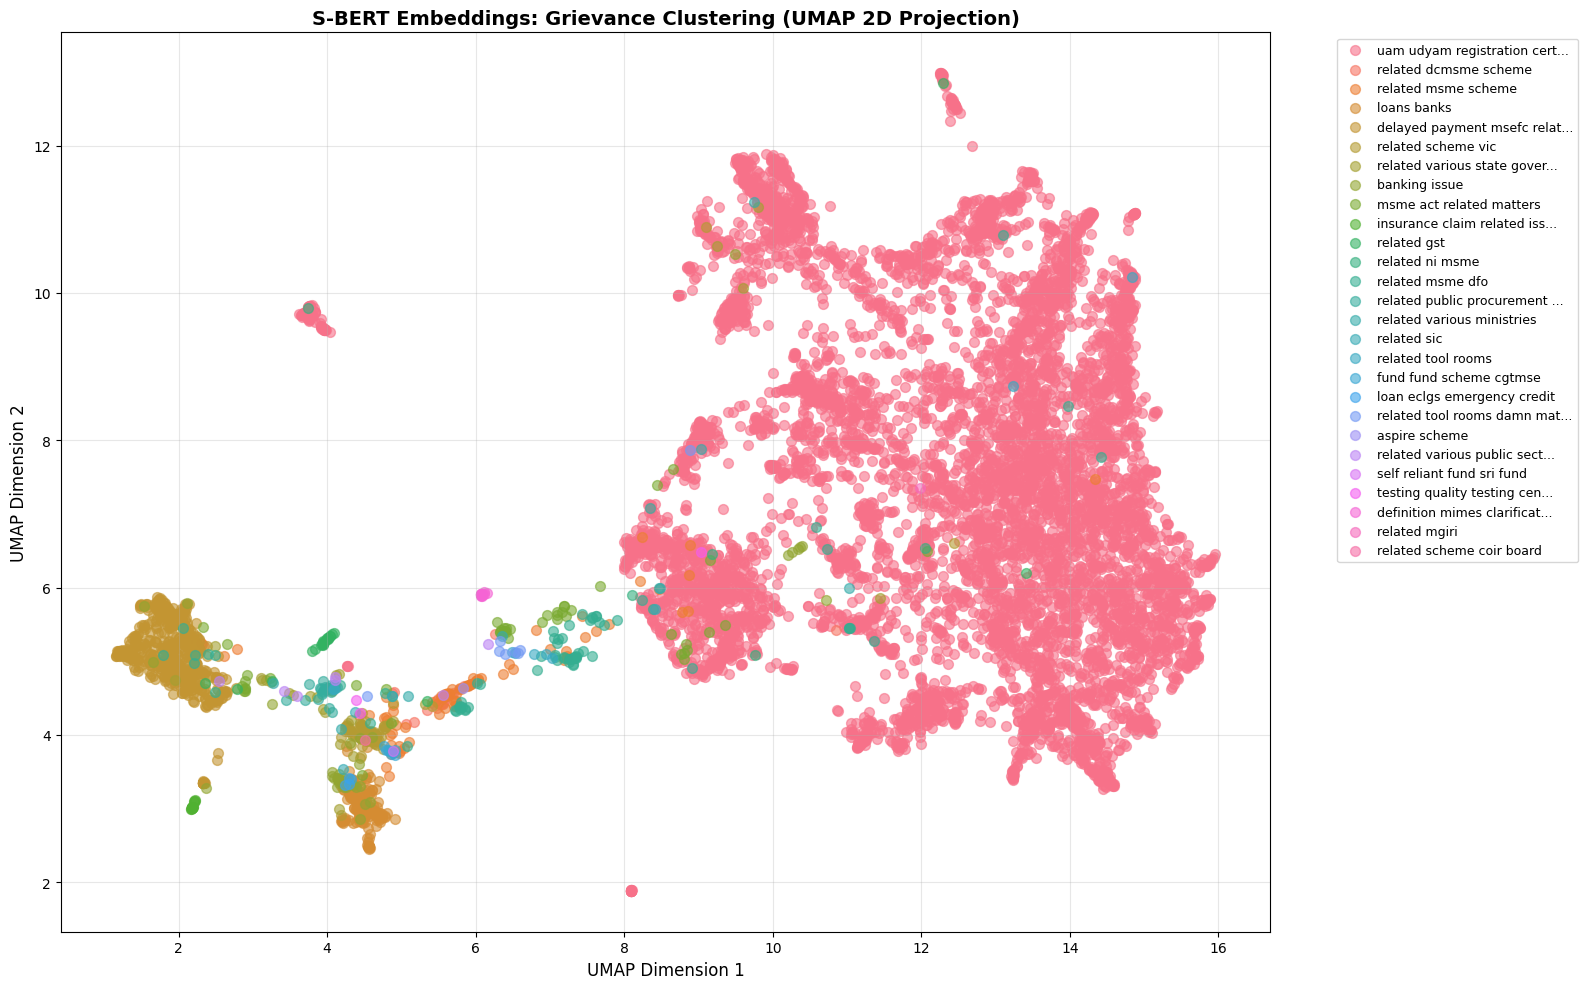


✓ Visualization complete!
  Each point represents a grievance in semantic space
  Similar grievances cluster together


In [13]:
# Dimensionality Reduction and Visualization of S-BERT Embeddings
# Using UMAP to reduce 384-dimensional embeddings to 2D for visualization
# This helps understand the semantic clustering of grievances

from umap import UMAP

# Apply UMAP for dimensionality reduction (384D → 2D)
print("Applying UMAP dimensionality reduction...")
umap_reducer = UMAP(n_components=2, 
                    n_neighbors=15, 
                    min_dist=0.1, 
                    metric='cosine',
                    random_state=42)

# Reduce combined embeddings
combined_2d = umap_reducer.fit_transform(combined_embeddings)
print(f"✓ UMAP reduction complete: {combined_embeddings.shape} → {combined_2d.shape}")

# Add 2D coordinates to dataframe
df_valid['umap_x'] = combined_2d[:, 0]
df_valid['umap_y'] = combined_2d[:, 1]

# Visualization: Scatter plot colored by category
plt.figure(figsize=(16, 10))
categories = df_valid[CATEGORY_COL].unique()
colors = sns.color_palette('husl', n_colors=len(categories))

for idx, category in enumerate(categories):
    mask = df_valid[CATEGORY_COL] == category
    plt.scatter(df_valid[mask]['umap_x'], 
                df_valid[mask]['umap_y'],
                c=[colors[idx]], 
                label=category if len(category) < 30 else category[:27] + '...',
                alpha=0.6,
                s=50)

plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.title('S-BERT Embeddings: Grievance Clustering (UMAP 2D Projection)', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Visualization complete!")
print(f"  Each point represents a grievance in semantic space")
print(f"  Similar grievances cluster together")

Computing semantic similarity for 500 grievances...
✓ Similarity matrix computed: (500, 500)

TOP 10 MOST SIMILAR GRIEVANCE PAIRS

PAIR #1 - Similarity Score: 0.9962
  Grievance 1 [uam udyam registration certificate related issues]:
    want update phone number email id uam br260075510 please update soon possible
  Grievance 2 [uam udyam registration certificate related issues]:
    want update phone number email id uam br12e0013357 please update soon possible
  ------------------------------------------------------------------------------

PAIR #2 - Similarity Score: 0.9953
  Grievance 1 [uam udyam registration certificate related issues]:
    udyam registration already done pan
  Grievance 2 [uam udyam registration certificate related issues]:
    problem udyam registration already done pan
  ------------------------------------------------------------------------------

PAIR #3 - Similarity Score: 0.9908
  Grievance 1 [uam udyam registration certificate related issues]:
    forgot u

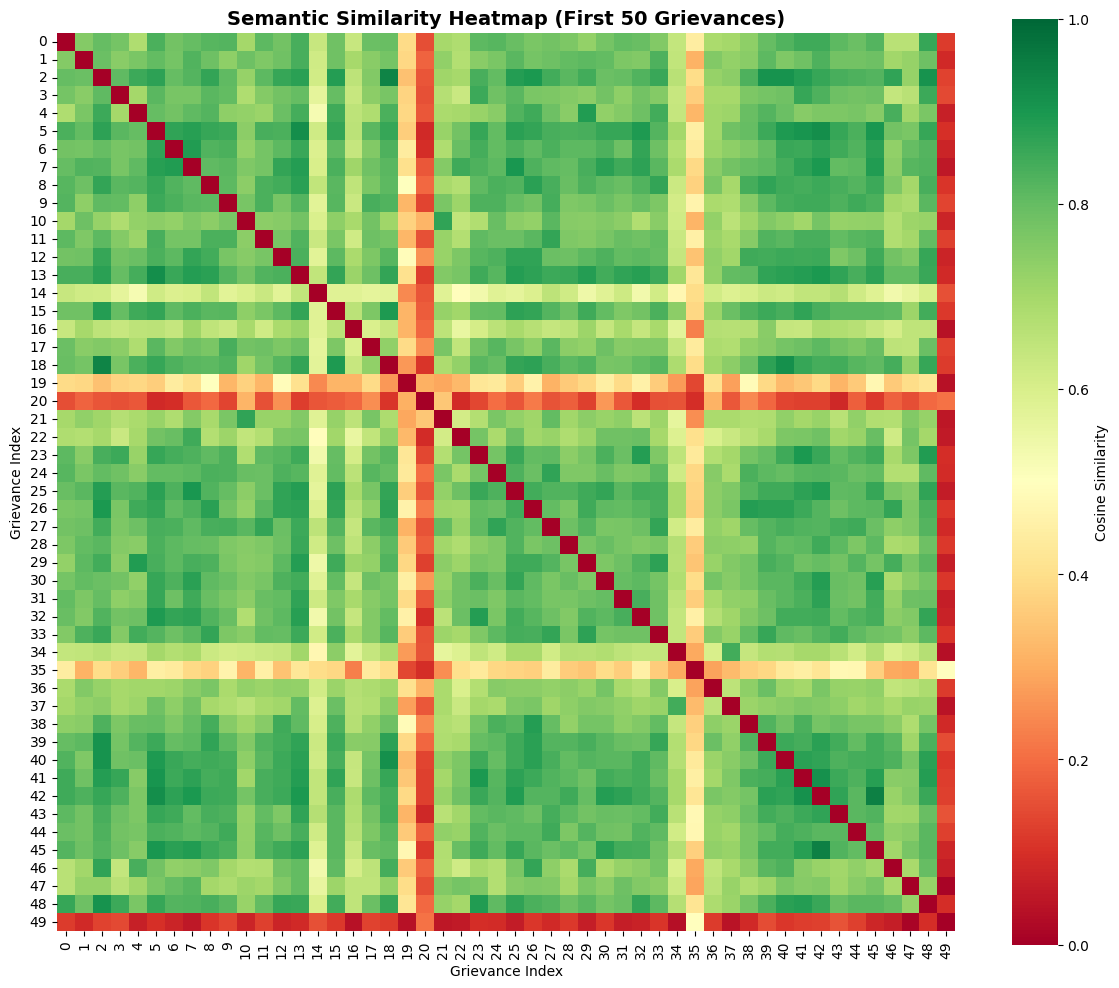


✓ Semantic similarity analysis complete!


In [14]:
# Semantic Similarity Analysis using S-BERT Embeddings
# Computing cosine similarity to find similar grievances
# This can help identify patterns and potential duplicates

from sklearn.metrics.pairwise import cosine_similarity

# Compute pairwise cosine similarity matrix (for a sample to avoid memory issues)
# For large datasets, we'll work with a sample
sample_size = min(500, len(df_valid))
sample_indices = np.random.choice(len(df_valid), sample_size, replace=False)
sample_embeddings = combined_embeddings[sample_indices]

print(f"Computing semantic similarity for {sample_size} grievances...")
similarity_matrix = cosine_similarity(sample_embeddings)
print(f"✓ Similarity matrix computed: {similarity_matrix.shape}")

# Find most similar pairs (excluding self-similarity)
np.fill_diagonal(similarity_matrix, -1)  # Ignore self-similarity

# Get top similar pairs
top_k = 10
similar_pairs = []
for i in range(len(similarity_matrix)):
    for j in range(i + 1, len(similarity_matrix)):
        similar_pairs.append((i, j, similarity_matrix[i, j]))

similar_pairs.sort(key=lambda x: x[2], reverse=True)

print(f"\n{'='*80}")
print(f"TOP {top_k} MOST SIMILAR GRIEVANCE PAIRS")
print(f"{'='*80}\n")

for rank, (idx1, idx2, sim_score) in enumerate(similar_pairs[:top_k], 1):
    real_idx1 = sample_indices[idx1]
    real_idx2 = sample_indices[idx2]
    
    cat1 = df_valid.iloc[real_idx1][CATEGORY_COL]
    cat2 = df_valid.iloc[real_idx2][CATEGORY_COL]
    desc1 = df_valid.iloc[real_idx1][DESC_COL]
    desc2 = df_valid.iloc[real_idx2][DESC_COL]
    
    print(f"PAIR #{rank} - Similarity Score: {sim_score:.4f}")
    print(f"  Grievance 1 [{cat1}]:")
    print(f"    {desc1[:150]}{'...' if len(desc1) > 150 else ''}")
    print(f"  Grievance 2 [{cat2}]:")
    print(f"    {desc2[:150]}{'...' if len(desc2) > 150 else ''}")
    print(f"  {'-'*78}\n")

# Visualize similarity matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix[:50, :50],  # Show first 50x50 for readability
            cmap='RdYlGn',
            vmin=0, 
            vmax=1,
            square=True,
            cbar_kws={'label': 'Cosine Similarity'})
plt.title(f'Semantic Similarity Heatmap (First 50 Grievances)', fontsize=14, fontweight='bold')
plt.xlabel('Grievance Index')
plt.ylabel('Grievance Index')
plt.tight_layout()
plt.show()

print(f"\n✓ Semantic similarity analysis complete!")

Applying HDBSCAN clustering on S-BERT embeddings...

HDBSCAN CLUSTERING RESULTS
  Number of clusters found: 14
  Noise points (outliers): 8228
  Clustered points: 703
  Clustering coverage: 7.87%

Cluster size distribution:
  Cluster  0:   55 grievances
  Cluster  1:   16 grievances
  Cluster  2:  192 grievances
  Cluster  3:   27 grievances
  Cluster  4:   18 grievances
  Cluster  5:   17 grievances
  Cluster  6:   11 grievances
  Cluster  7:   10 grievances
  Cluster  8:   92 grievances
  Cluster  9:   22 grievances
  Cluster 10:   11 grievances
  Cluster 11:   30 grievances
  Cluster 12:  152 grievances
  Cluster 13:   50 grievances


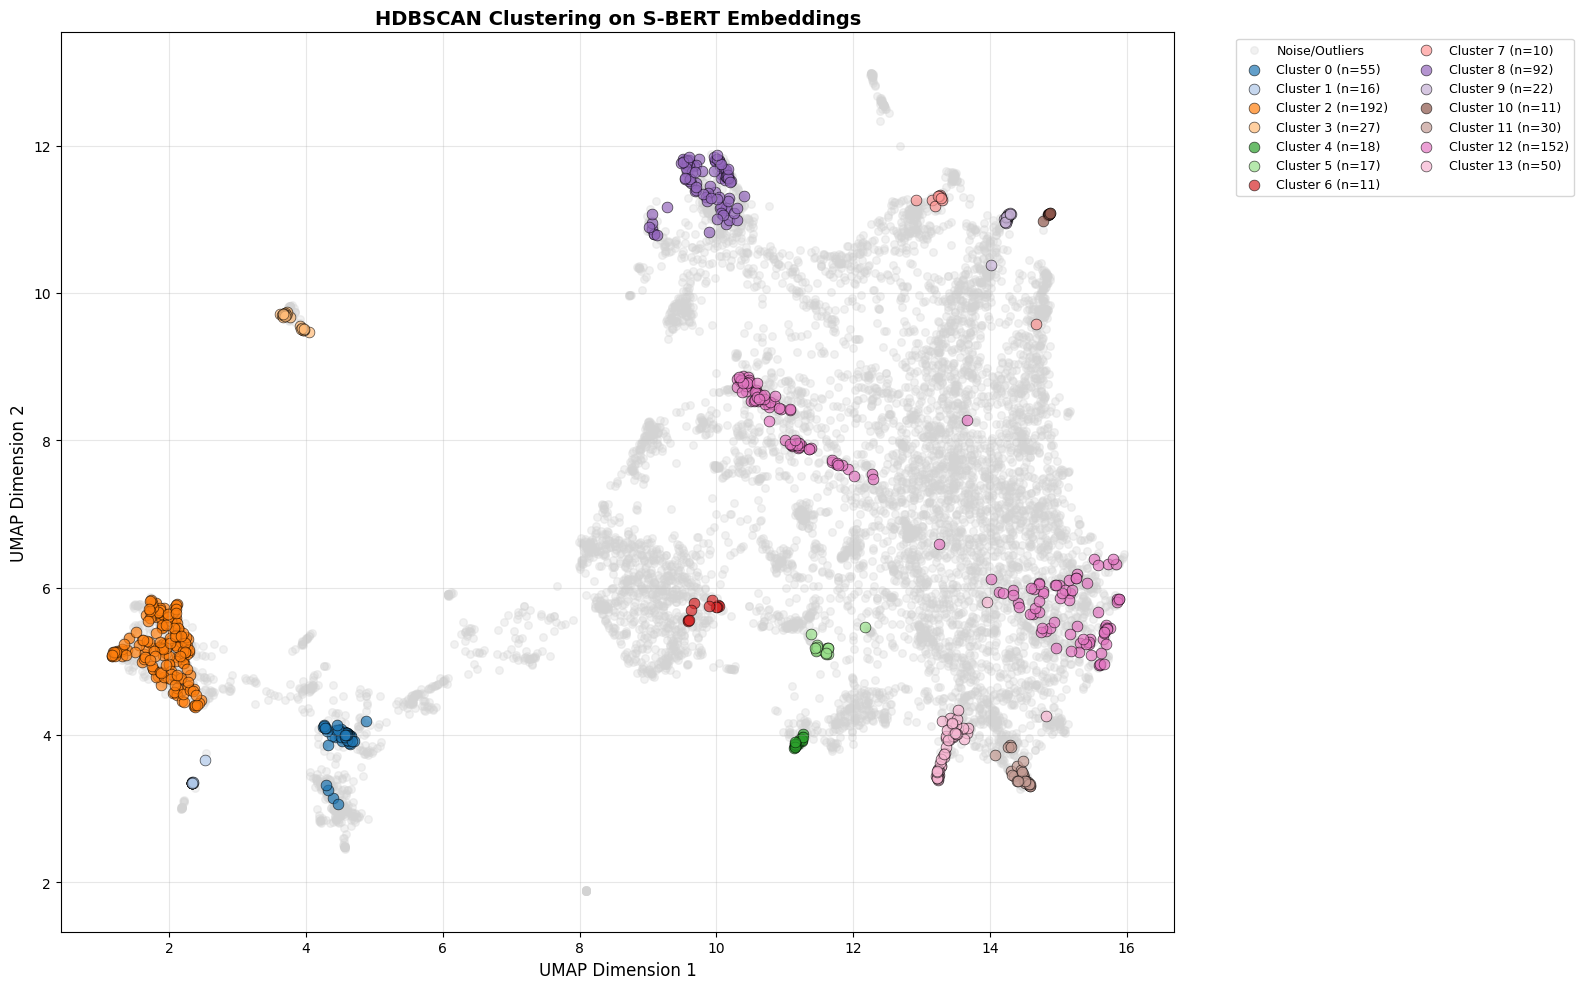


✓ Clustering visualization complete!


In [15]:
# HDBSCAN Clustering on S-BERT Embeddings
# Density-based clustering to discover natural groupings in grievances
# HDBSCAN automatically determines the number of clusters

import hdbscan
from collections import Counter

print("Applying HDBSCAN clustering on S-BERT embeddings...")
clusterer = hdbscan.HDBSCAN(min_cluster_size=10,
                            min_samples=5,
                            metric='euclidean',
                            cluster_selection_method='eom')

# Fit on combined embeddings
cluster_labels = clusterer.fit_predict(combined_embeddings)
df_valid['cluster_label'] = cluster_labels

# Cluster statistics
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"\n{'='*80}")
print(f"HDBSCAN CLUSTERING RESULTS")
print(f"{'='*80}")
print(f"  Number of clusters found: {n_clusters}")
print(f"  Noise points (outliers): {n_noise}")
print(f"  Clustered points: {len(cluster_labels) - n_noise}")
print(f"  Clustering coverage: {((len(cluster_labels) - n_noise) / len(cluster_labels) * 100):.2f}%")

# Cluster size distribution
cluster_counts = Counter(cluster_labels)
print(f"\nCluster size distribution:")
for cluster_id in sorted(cluster_counts.keys()):
    if cluster_id != -1:
        count = cluster_counts[cluster_id]
        print(f"  Cluster {cluster_id:2d}: {count:4d} grievances")

# Visualize clusters on UMAP projection
plt.figure(figsize=(16, 10))

# Plot noise points
noise_mask = df_valid['cluster_label'] == -1
if noise_mask.sum() > 0:
    plt.scatter(df_valid[noise_mask]['umap_x'],
                df_valid[noise_mask]['umap_y'],
                c='lightgray',
                label='Noise/Outliers',
                alpha=0.3,
                s=30)

# Plot clusters
unique_clusters = [c for c in df_valid['cluster_label'].unique() if c != -1]
colors = sns.color_palette('tab20', n_colors=len(unique_clusters))

for idx, cluster_id in enumerate(sorted(unique_clusters)):
    mask = df_valid['cluster_label'] == cluster_id
    plt.scatter(df_valid[mask]['umap_x'],
                df_valid[mask]['umap_y'],
                c=[colors[idx]],
                label=f'Cluster {cluster_id} (n={mask.sum()})',
                alpha=0.7,
                s=60,
                edgecolors='black',
                linewidth=0.5)

plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.title('HDBSCAN Clustering on S-BERT Embeddings', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Clustering visualization complete!")

In [16]:
# Cluster Characterization: Analyze top themes in each cluster
# Extract representative grievances and common keywords per cluster

from collections import Counter
import pandas as pd

print("="*80)
print("CLUSTER CHARACTERIZATION")
print("="*80)

# Analyze top 5 largest clusters
cluster_sizes = df_valid['cluster_label'].value_counts()
top_clusters = [c for c in cluster_sizes.index if c != -1][:5]

for cluster_id in top_clusters:
    cluster_data = df_valid[df_valid['cluster_label'] == cluster_id]
    
    print(f"\n{'─'*80}")
    print(f"CLUSTER {cluster_id} - {len(cluster_data)} grievances")
    print(f"{'─'*80}")
    
    # Category distribution in this cluster
    category_dist = cluster_data[CATEGORY_COL].value_counts().head(3)
    print(f"\nTop Categories:")
    for cat, count in category_dist.items():
        print(f"  • {cat}: {count} ({count/len(cluster_data)*100:.1f}%)")
    
    # Extract common words from descriptions
    all_words = []
    for desc in cluster_data[DESC_COL]:
        if desc and isinstance(desc, str):
            all_words.extend(desc.split())
    
    word_counts = Counter(all_words)
    common_words = word_counts.most_common(15)
    
    print(f"\nMost Common Terms:")
    print(f"  {', '.join([f'{word}({count})' for word, count in common_words])}")
    
    # Sample grievances
    print(f"\nRepresentative Grievances (samples):")
    samples = cluster_data.head(3)
    for i, (idx, row) in enumerate(samples.iterrows(), 1):
        cat = row[CATEGORY_COL]
        desc = row[DESC_COL]
        print(f"  {i}. [{cat}]")
        print(f"     {desc[:200]}{'...' if len(desc) > 200 else ''}")
        print()

print(f"\n{'='*80}")
print("✓ Cluster characterization complete!")
print(f"{'='*80}")

# Summary statistics
print(f"\n📊 SUMMARY STATISTICS")
print(f"  Total grievances analyzed: {len(df_valid)}")
print(f"  S-BERT embedding dimension: {category_embeddings.shape[1]}")
print(f"  Number of discovered clusters: {n_clusters}")
print(f"  Average cluster size: {(len(df_valid) - n_noise) / n_clusters:.1f}" if n_clusters > 0 else "  No clusters found")
print(f"  Largest cluster size: {cluster_sizes[cluster_sizes.index != -1].max() if len(cluster_sizes[cluster_sizes.index != -1]) > 0 else 0}")
print(f"  Smallest cluster size: {cluster_sizes[cluster_sizes.index != -1].min() if len(cluster_sizes[cluster_sizes.index != -1]) > 0 else 0}")

CLUSTER CHARACTERIZATION

────────────────────────────────────────────────────────────────────────────────
CLUSTER 2 - 192 grievances
────────────────────────────────────────────────────────────────────────────────

Top Categories:
  • delayed payment msefc related issues: 192 (100.0%)

Most Common Terms:
  payment(174), case(135), msme(134), application(133), udyam(101), date(73), kindly(69), please(66), sir(62), portal(58), delayed(58), rs(55), us(53), registration(52), council(50)

Representative Grievances (samples):
  1. [delayed payment msefc related issues]
     write bring esteemed attention filed case msme samadhan portal september matter pertains delayed payment rs helplab healthcare pvt ltd petitioner para trade links respondent despite considerable time ...

  2. [delayed payment msefc related issues]
     write bring esteemed attention filed case msme samadhan portal 25th april matter pertains delayed payment rs helplab healthcare pvt ltd petitioner abhishek kumar srivasta

# Hierarchical Clustering: Category-wise Sub-categorization

## Approach
For each main category in the dataset, we will:
1. Identify sub-categories (clusters) within that category
2. The number of clusters is proportional to the category size
3. Extract key themes and phrases for each sub-category
4. Provide representative samples

**Cluster Size Heuristic:**
- Categories with 7000+ grievances → 10-15 sub-categories
- Categories with 500-1000 grievances → 3-5 sub-categories
- Categories with 100-500 grievances → 2-4 sub-categories
- Categories with 50-100 grievances → 2-3 sub-categories
- Categories with < 50 grievances → Skip (insufficient data)

In [18]:
# Hierarchical Category-wise Clustering Implementation
# For each main category, identify sub-categories using HDBSCAN clustering

from sklearn.feature_extraction.text import TfidfVectorizer
import hdbscan
from collections import Counter, defaultdict
import json

# Get original (untranslated/unprocessed) category names for better readability
# We'll map back from processed to original
df_original = pd.read_excel("D:\\IndiaAI\\Champions Code\\Dataset\\Champion_Data.xlsx")

# Category analysis - filter categories with >50 grievances
category_counts = df_valid[CATEGORY_COL].value_counts()
eligible_categories = category_counts[category_counts >= 50]

print("="*100)
print("HIERARCHICAL CLUSTERING: CATEGORY-WISE SUB-CATEGORIZATION")
print("="*100)
print(f"\nTotal unique categories: {len(category_counts)}")
print(f"Categories with ≥50 grievances: {len(eligible_categories)}")
print(f"Total grievances to analyze: {eligible_categories.sum()}")
print("\nCategory Distribution (Top 10):")
for i, (cat, count) in enumerate(eligible_categories.head(10).items(), 1):
    print(f"  {i:2d}. {cat[:60]:<60s} → {count:5d} grievances")

# Determine optimal cluster size based on category size
def get_optimal_clusters(size):
    """Heuristic for determining min_cluster_size based on category size"""
    if size >= 5000:
        return 15, max(15, size // 700)  # min_size, expected clusters
    elif size >= 1000:
        return 8, max(5, size // 200)
    elif size >= 500:
        return 5, max(3, size // 150)
    elif size >= 200:
        return 5, max(3, size // 80)
    elif size >= 100:
        return 4, max(2, size // 50)
    else:
        return 3, max(2, size // 30)

# Store hierarchical results
hierarchical_results = {}

HIERARCHICAL CLUSTERING: CATEGORY-WISE SUB-CATEGORIZATION

Total unique categories: 27
Categories with ≥50 grievances: 6
Total grievances to analyze: 8643

Category Distribution (Top 10):
   1. uam udyam registration certificate related issues            →  7659 grievances
   2. delayed payment msefc related issues                         →   524 grievances
   3. loans banks                                                  →   194 grievances
   4. related scheme vic                                           →   105 grievances
   5. related msme scheme                                          →    89 grievances
   6. related msme dfo                                             →    72 grievances


In [23]:
df.head()

,GrievanceNo,Gims_CategoryName,State,CreatedDate,ReplyStatus,GrievanceDescription,FinalReply,FinalReplyDate
0,UP00135828,uam udyam registration certificate related issues,UTTAR PRADESH,2024-12-30,Replied,please find attachment letter head,sir please upload clear image aadhar card pan ...,2024-12-31
1,BR00135827,uam udyam registration certificate related issues,BIHAR,2024-12-30,Replied,udyam udyam br address wrong want cancel prere...,sir per request advised send details signed co...,2024-12-31
2,MH00135826,uam udyam registration certificate related issues,MAHARASHTRA,2024-12-30,Replied,udyog aadhaar registration authority dear sir ...,grievance change registered mobile number requ...,2025-01-01
3,CG00135825,uam udyam registration certificate related issues,CHHATTISGARH,2024-12-30,Replied,regarding udyam registration even multiple att...,provided pan registered udyam udyam cg satan k...,2025-01-03
4,CG00135824,uam udyam registration certificate related issues,CHHATTISGARH,2024-12-30,Replied,grievance regarding udyam registration even mu...,provided pan registered udyam udyam cg satan k...,2025-01-03


In [24]:
# Process each category and perform hierarchical clustering
# This cell performs the actual clustering for each main category

print("\n" + "="*100)
print("PROCESSING EACH CATEGORY...")
print("="*100 + "\n")

category_counter = 0

for main_category in eligible_categories.head(10).index:  # Process top 10 categories
    category_counter += 1
    cat_data = df_valid[df_valid[CATEGORY_COL] == main_category].copy()
    cat_size = len(cat_data)
    
    # Get original category name (before preprocessing)
    try:
        # Find first matching original category
        original_idx = cat_data.index[0]
        original_category = df.iloc[original_idx]['Gims_CategoryName']
    except:
        original_category = main_category
    
    print(f"{'─'*100}")
    print(f"[{category_counter}/10] {original_category}")
    print(f"{'─'*100}")
    print(f"Data Size: {cat_size} grievances")
    
    # Determine optimal clustering parameters
    min_cluster_size, expected_clusters = get_optimal_clusters(cat_size)
    print(f"Clustering Strategy: min_cluster_size={min_cluster_size}, expected ~{expected_clusters} sub-categories")
    
    # Extract embeddings for this category
    cat_indices = cat_data.index
    cat_embeddings = description_embeddings[df_valid.index.isin(cat_indices)]
    
    # Apply HDBSCAN clustering
    cat_clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=max(3, min_cluster_size // 2),
        metric='euclidean',
        cluster_selection_method='eom'
    )
    
    cat_cluster_labels = cat_clusterer.fit_predict(cat_embeddings)
    cat_data['sub_cluster'] = cat_cluster_labels
    
    # Cluster statistics
    n_subclusters = len(set(cat_cluster_labels)) - (1 if -1 in cat_cluster_labels else 0)
    n_cat_noise = list(cat_cluster_labels).count(-1)
    
    print(f"✓ Sub-categories Identified: {n_subclusters}")
    print(f"  - Clustered: {cat_size - n_cat_noise} ({(cat_size - n_cat_noise)/cat_size*100:.1f}%)")
    print(f"  - Noise/Outliers: {n_cat_noise} ({n_cat_noise/cat_size*100:.1f}%)")
    
    # Analyze each sub-cluster
    cluster_profiles = {}
    cluster_counts = Counter(cat_cluster_labels)
    
    print(f"\nSub-category Breakdown:")
    for sub_id in sorted([c for c in cluster_counts.keys() if c != -1]):
        sub_data = cat_data[cat_data['sub_cluster'] == sub_id]
        sub_size = len(sub_data)
        
        # Extract key phrases using TF-IDF
        descriptions = sub_data[DESC_COL].fillna('').astype(str).tolist()
        
        if len(descriptions) >= 3:
            try:
                tfidf = TfidfVectorizer(max_features=10, ngram_range=(1, 3), max_df=0.8, min_df=2)
                tfidf_matrix = tfidf.fit_transform(descriptions)
                key_phrases = tfidf.get_feature_names_out().tolist()
            except:
                # Fallback to word frequency
                all_tokens = ' '.join(descriptions).split()
                word_freq = Counter(all_tokens)
                key_phrases = [word for word, _ in word_freq.most_common(10)]
        else:
            key_phrases = []
        
        # Get representative samples
        samples = sub_data.head(3)[DESC_COL].tolist()
        
        # Infer cluster name from key phrases
        if len(key_phrases) >= 3:
            cluster_name = f"Sub-category {sub_id}: {' + '.join(key_phrases[:3])}"
        else:
            cluster_name = f"Sub-category {sub_id}"
        
        cluster_profiles[sub_id] = {
            'name': cluster_name,
            'size': sub_size,
            'percentage': f"{sub_size/cat_size*100:.1f}%",
            'key_phrases': key_phrases,
            'samples': samples
        }
        
        print(f"  ├─ Cluster {sub_id}: {sub_size:4d} grievances ({sub_size/cat_size*100:.1f}%)")
        print(f"  │  ├─ Key phrases: {', '.join(key_phrases[:5])}")
    
    # Store results
    hierarchical_results[original_category] = {
        'data_size': cat_size,
        'clusters_identified': n_subclusters,
        'noise_count': n_cat_noise,
        'cluster_profiles': cluster_profiles
    }
    
    print()

print("="*100)
print(f"✓ Hierarchical clustering complete for {category_counter} categories!")
print("="*100)


PROCESSING EACH CATEGORY...

────────────────────────────────────────────────────────────────────────────────────────────────────
[1/10] uam udyam registration certificate related issues
────────────────────────────────────────────────────────────────────────────────────────────────────
Data Size: 7659 grievances
Clustering Strategy: min_cluster_size=15, expected ~15 sub-categories
✓ Sub-categories Identified: 6
  - Clustered: 698 (9.1%)
  - Noise/Outliers: 6961 (90.9%)

Sub-category Breakdown:
  ├─ Cluster 0:   40 grievances (0.5%)
  │  ├─ Key phrases: email id, mobile, mobile number, mobile number email, number email
  ├─ Cluster 1:   26 grievances (0.3%)
  │  ├─ Key phrases: change, change mobile, change mobile number, email id mobile, id mobile
  ├─ Cluster 2:   19 grievances (0.2%)
  │  ├─ Key phrases: aadhar, email, email id, error, id
  ├─ Cluster 3:   15 grievances (0.2%)
  │  ├─ Key phrases: also, lost, nisan, prasad, sad
  ├─ Cluster 4:  550 grievances (7.2%)
  │  ├─ Key phr

In [25]:
# Display Hierarchical Structure in Tree Format
# Beautiful visualization of the hierarchical category structure

print("\n" + "🔷"*50)
print("HIERARCHICAL GRIEVANCE TAXONOMY")
print("🔷"*50 + "\n")

for idx, (main_cat, info) in enumerate(hierarchical_results.items(), 1):
    print(f"\n{'█'*100}")
    print(f"📁 CATEGORY {idx}: {main_cat}")
    print(f"{'█'*100}")
    print(f"│")
    print(f"├── Data Size: {info['data_size']} grievances")
    print(f"├── Sub-categories Identified: {info['clusters_identified']}")
    print(f"├── Coverage: {info['data_size'] - info['noise_count']}/{info['data_size']} ({(info['data_size']-info['noise_count'])/info['data_size']*100:.1f}%)")
    print(f"│")
    print(f"└── 📊 SUB-CATEGORY PROFILES:")
    
    cluster_profiles = info['cluster_profiles']
    num_clusters = len(cluster_profiles)
    
    for sub_idx, (cluster_id, profile) in enumerate(sorted(cluster_profiles.items()), 1):
        is_last = (sub_idx == num_clusters)
        branch = "└──" if is_last else "├──"
        cont = "    " if is_last else "│   "
        
        print(f"    {branch} 🔹 Cluster {cluster_id}: {profile['size']} grievances ({profile['percentage']})")
        print(f"    {cont} │")
        print(f"    {cont} ├─ 🏷️  Key Phrases:")
        
        key_phrases = profile['key_phrases'][:8]
        for phrase in key_phrases:
            print(f"    {cont} │   • {phrase}")
        
        print(f"    {cont} │")
        print(f"    {cont} └─ 📝 Representative Samples:")
        
        for sample_idx, sample in enumerate(profile['samples'][:2], 1):
            sample_text = sample[:120] + '...' if len(sample) > 120 else sample
            print(f"    {cont}     {sample_idx}. {sample_text}")
        
        if not is_last:
            print(f"    {cont}")

print(f"\n{'='*100}")
print(f"✓ Hierarchical taxonomy displayed for {len(hierarchical_results)} categories")
print(f"{'='*100}")


🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷
HIERARCHICAL GRIEVANCE TAXONOMY
🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷🔷


████████████████████████████████████████████████████████████████████████████████████████████████████
📁 CATEGORY 1: UAM/Udyam Registration/Certificate related issues
████████████████████████████████████████████████████████████████████████████████████████████████████
│
├── Data Size: 7659 grievances
├── Sub-categories Identified: 6
├── Coverage: 698/7659 (9.1%)
│
└── 📊 SUB-CATEGORY PROFILES:
    ├── 🔹 Cluster 0: 40 grievances (0.5%)
    │    │
    │    ├─ 🏷️  Key Phrases:
    │    │   • email id
    │    │   • mobile
    │    │   • mobile number
    │    │   • mobile number email
    │    │   • number email
    │    │   • number email id
    │    │   • please
    │    │   • please update
    │    │
    │    └─ 📝 Representative Samples:
    │        1. want update phone number email id uam br26d0018623
    │        2. want update phone number email id ua

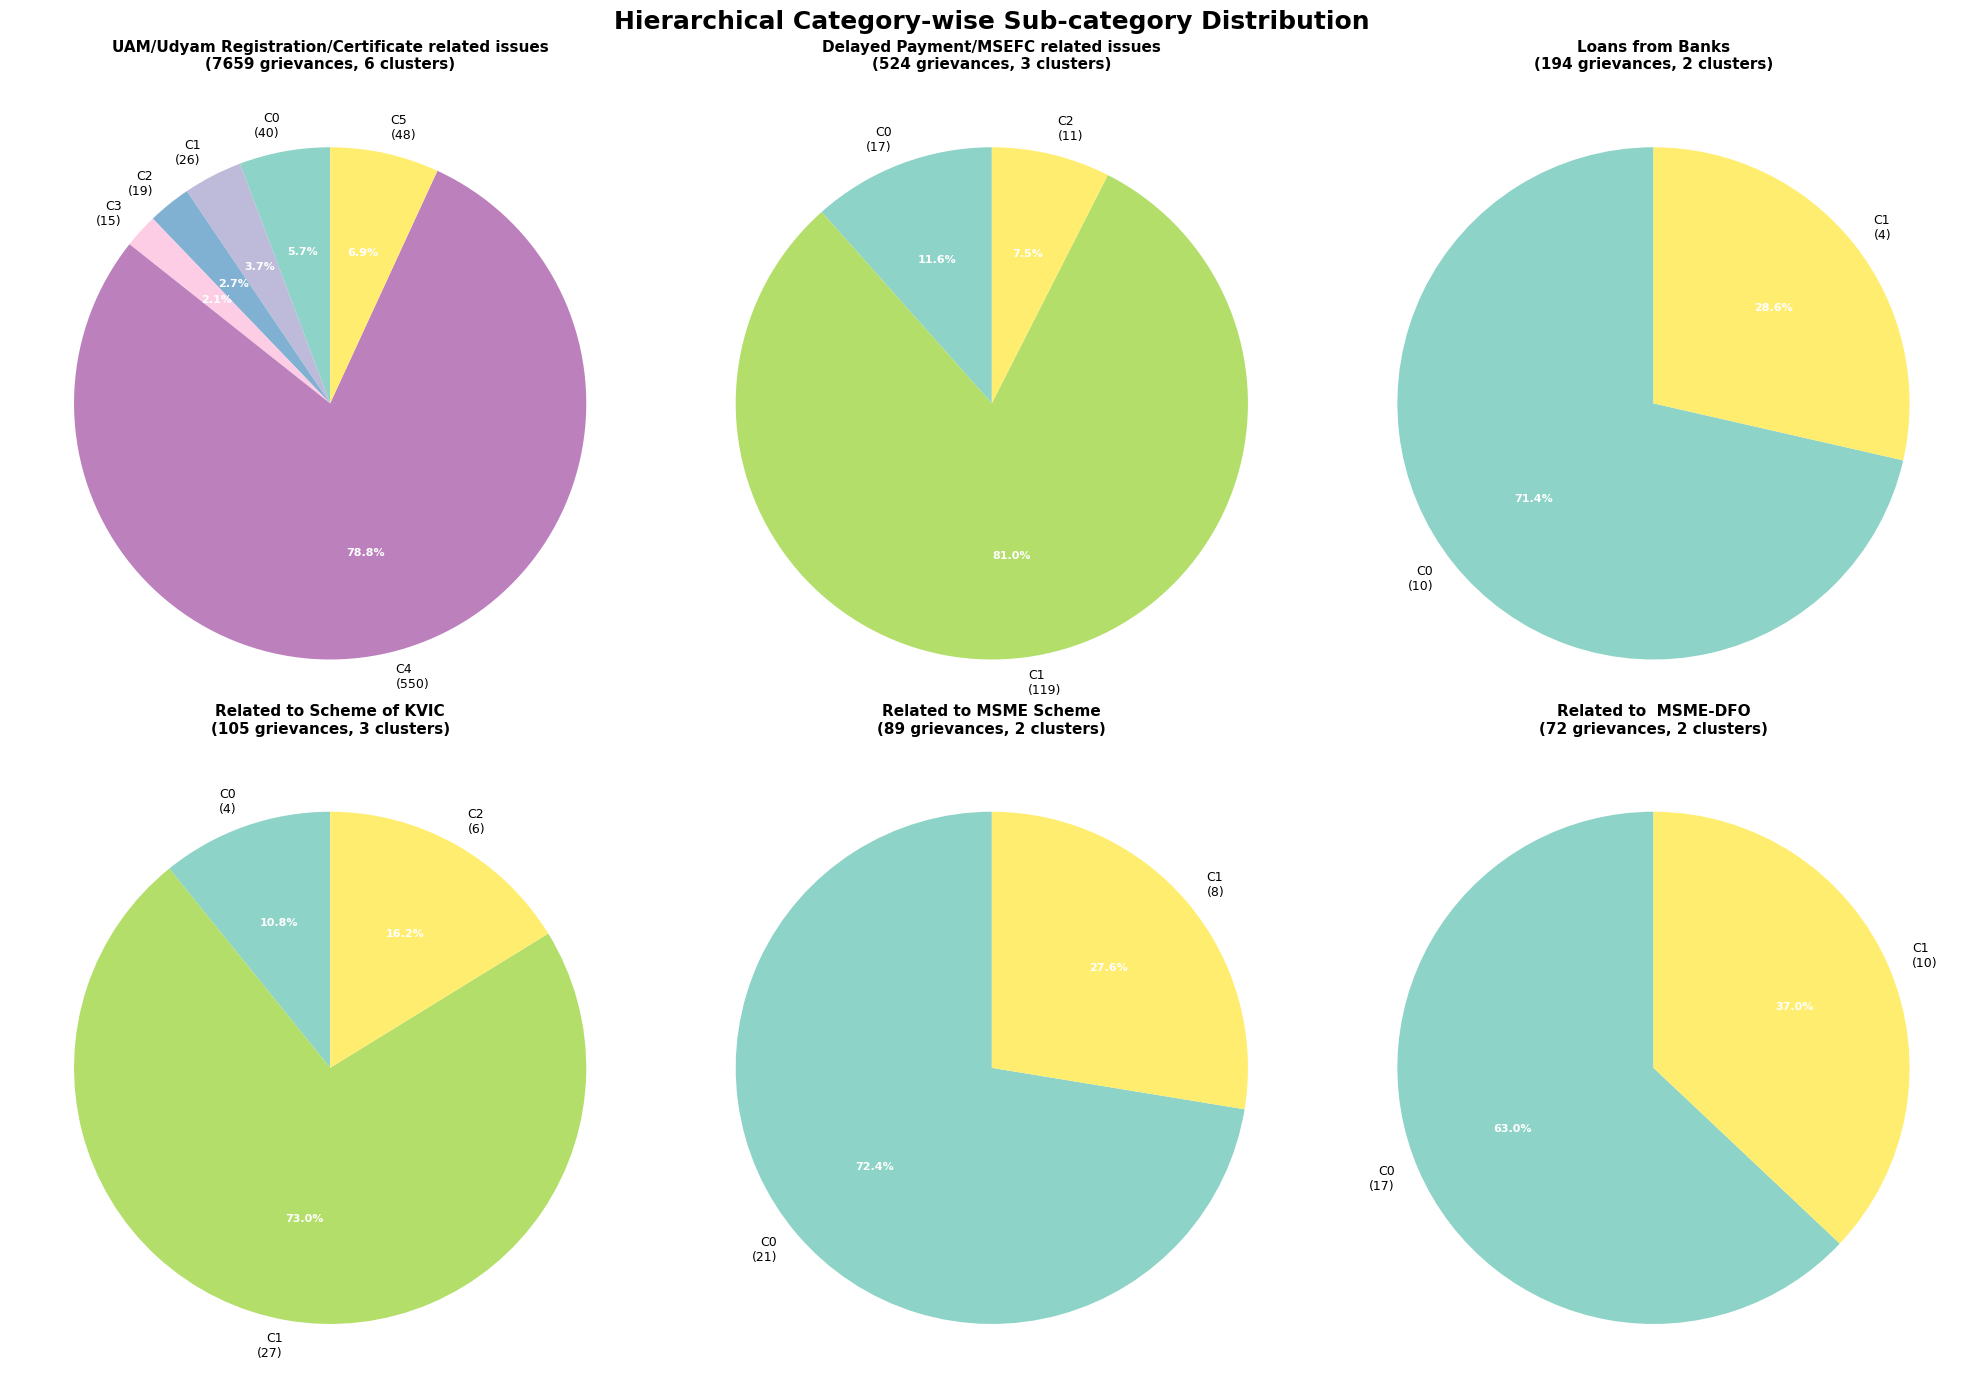

✓ Visualization 1: Pie charts showing sub-category distribution per main category


In [26]:
# Visualization 1: Hierarchical Sunburst Chart
# Interactive visualization showing category hierarchy

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import numpy as np

# Prepare data for sunburst visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle('Hierarchical Category-wise Sub-category Distribution', 
             fontsize=18, fontweight='bold', y=0.995)

axes = axes.flatten()

for idx, (main_cat, info) in enumerate(list(hierarchical_results.items())[:6]):
    ax = axes[idx]
    
    cluster_profiles = info['cluster_profiles']
    
    # Data for pie chart
    sizes = [profile['size'] for profile in cluster_profiles.values()]
    labels = [f"C{cid}\n({profile['size']})" for cid, profile in cluster_profiles.items()]
    colors = plt.cm.Set3(np.linspace(0, 1, len(sizes)))
    
    # Create pie chart
    wedges, texts, autotexts = ax.pie(sizes, 
                                        labels=labels,
                                        colors=colors,
                                        autopct='%1.1f%%',
                                        startangle=90,
                                        textprops={'fontsize': 9})
    
    # Enhance text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(8)
    
    # Title with category name (truncated)
    title = main_cat[:50] + '...' if len(main_cat) > 50 else main_cat
    ax.set_title(f"{title}\n({info['data_size']} grievances, {info['clusters_identified']} clusters)",
                fontsize=11, fontweight='bold', pad=10)

plt.tight_layout()
plt.show()

print("✓ Visualization 1: Pie charts showing sub-category distribution per main category")

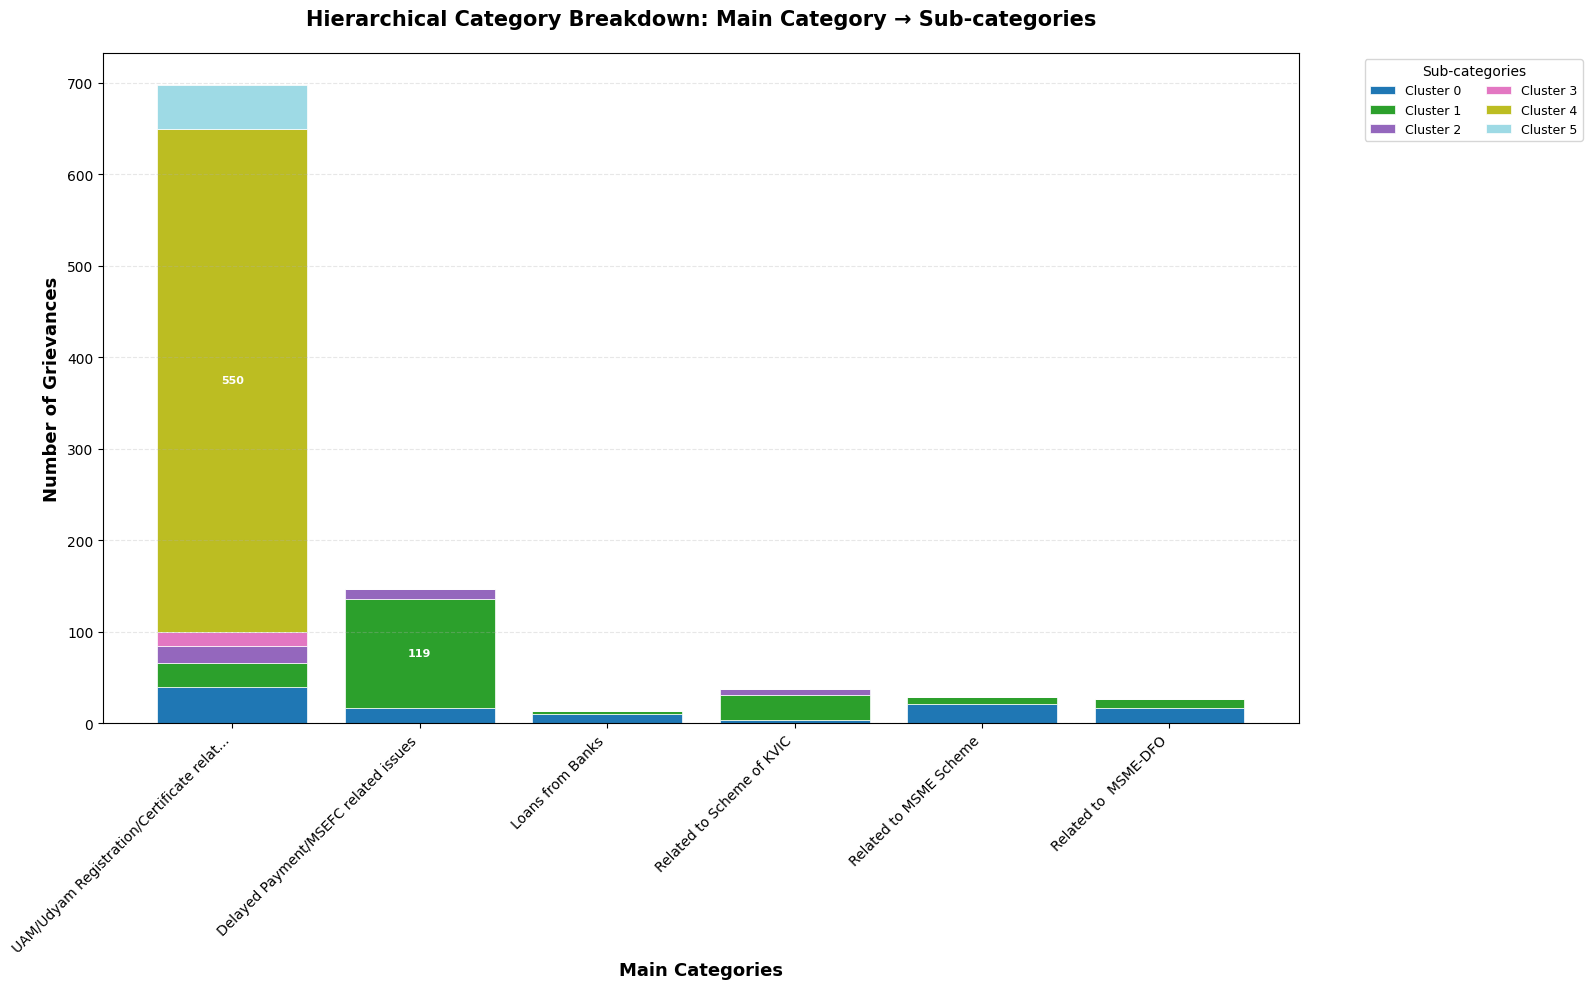

✓ Visualization 2: Stacked bar chart showing hierarchical distribution


In [22]:
# Visualization 2: Stacked Bar Chart - Category vs Sub-category Distribution
# Shows the breakdown of each category into its sub-categories

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(16, 10))

# Prepare data
categories = list(hierarchical_results.keys())[:8]  # Top 8 categories
category_labels = [cat[:40] + '...' if len(cat) > 40 else cat for cat in categories]

# Find maximum number of clusters across all categories
max_clusters = max(len(info['cluster_profiles']) for info in hierarchical_results.values())

# Prepare data matrix
data_matrix = np.zeros((len(categories), max_clusters))
cluster_names = []

for cat_idx, (main_cat, info) in enumerate(list(hierarchical_results.items())[:8]):
    cluster_profiles = info['cluster_profiles']
    for cluster_idx, (cluster_id, profile) in enumerate(sorted(cluster_profiles.items())):
        data_matrix[cat_idx, cluster_idx] = profile['size']

# Create stacked bar chart
x_pos = np.arange(len(categories))
colors = plt.cm.tab20(np.linspace(0, 1, max_clusters))

bottom = np.zeros(len(categories))
for cluster_idx in range(max_clusters):
    values = data_matrix[:, cluster_idx]
    bars = ax.bar(x_pos, values, bottom=bottom, 
                   color=colors[cluster_idx], 
                   label=f'Cluster {cluster_idx}',
                   edgecolor='white', linewidth=0.5)
    
    # Add value labels on bars
    for bar_idx, (bar, value) in enumerate(zip(bars, values)):
        if value > 0:
            height = bar.get_height()
            if height > 100:  # Only label if significant size
                ax.text(bar.get_x() + bar.get_width()/2., bottom[bar_idx] + height/2.,
                       f'{int(value)}',
                       ha='center', va='center', fontsize=8, color='white', fontweight='bold')
    
    bottom += values

ax.set_xlabel('Main Categories', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Grievances', fontsize=13, fontweight='bold')
ax.set_title('Hierarchical Category Breakdown: Main Category → Sub-categories', 
            fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(category_labels, rotation=45, ha='right', fontsize=10)
ax.legend(title='Sub-categories', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=9)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("✓ Visualization 2: Stacked bar chart showing hierarchical distribution")

In [ ]:
# Visualization 3: Treemap - Hierarchical Size Representation
# Shows the relative size of categories and their sub-categories

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import squarify  # You may need to install: pip install squarify

# Alternative implementation without squarify dependency
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Sub-category Size Distribution within Main Categories', 
             fontsize=18, fontweight='bold', y=0.995)

axes = axes.flatten()

for idx, (main_cat, info) in enumerate(list(hierarchical_results.items())[:4]):
    ax = axes[idx]
    
    cluster_profiles = info['cluster_profiles']
    
    # Prepare data
    sizes = [profile['size'] for profile in cluster_profiles.values()]
    labels = [f"Cluster {cid}\n{profile['size']} ({profile['percentage']})\n{', '.join(profile['key_phrases'][:2])}" 
              for cid, profile in cluster_profiles.items()]
    
    try:
        # Try using squarify if available
        colors = plt.cm.Pastel1(np.linspace(0, 1, len(sizes)))
        squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, ax=ax,
                     text_kwargs={'fontsize': 9, 'weight': 'bold'})
        ax.axis('off')
    except:
        # Fallback to horizontal bar chart
        y_pos = np.arange(len(sizes))
        colors = plt.cm.Pastel1(np.linspace(0, 1, len(sizes)))
        bars = ax.barh(y_pos, sizes, color=colors, edgecolor='black', linewidth=0.5)
        
        # Add value labels
        for i, (bar, size) in enumerate(zip(bars, sizes)):
            ax.text(size + max(sizes)*0.01, bar.get_y() + bar.get_height()/2,
                   f'{size}', va='center', fontsize=10, fontweight='bold')
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels([f"Cluster {cid}" for cid in cluster_profiles.keys()], fontsize=10)
        ax.set_xlabel('Number of Grievances', fontsize=11, fontweight='bold')
        ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Title
    title = main_cat[:60] + '...' if len(main_cat) > 60 else main_cat
    ax.set_title(f"{title}\n({info['data_size']} total grievances)",
                fontsize=12, fontweight='bold', pad=10)

plt.tight_layout()
plt.show()

print("✓ Visualization 3: Treemap/Bar chart showing relative sub-category sizes")

In [ ]:
# Export Hierarchical Results to JSON
# Save the hierarchical taxonomy for future reference and analysis

import json
from datetime import datetime

# Prepare export data
export_data = {
    'metadata': {
        'generated_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'total_categories': len(hierarchical_results),
        'total_grievances_analyzed': sum(info['data_size'] for info in hierarchical_results.values()),
        'embedding_model': 'sentence-transformers/all-MiniLM-L6-v2',
        'clustering_algorithm': 'HDBSCAN'
    },
    'hierarchical_taxonomy': {}
}

for main_cat, info in hierarchical_results.items():
    export_data['hierarchical_taxonomy'][main_cat] = {
        'data_size': info['data_size'],
        'clusters_identified': info['clusters_identified'],
        'noise_count': info['noise_count'],
        'coverage_percentage': f"{(info['data_size']-info['noise_count'])/info['data_size']*100:.2f}%",
        'cluster_profiles': {}
    }
    
    for cluster_id, profile in info['cluster_profiles'].items():
        export_data['hierarchical_taxonomy'][main_cat]['cluster_profiles'][f'cluster_{cluster_id}'] = {
            'size': profile['size'],
            'percentage': profile['percentage'],
            'key_phrases': profile['key_phrases'],
            'representative_samples': profile['samples'][:3]
        }

# Save to JSON file
output_path = "D:\\Shridhar\\Data Science && Data Analytics\\Dummy\\hierarchical_grievance_taxonomy.json"
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(export_data, f, indent=2, ensure_ascii=False)

print("="*100)
print("📁 HIERARCHICAL TAXONOMY EXPORTED")
print("="*100)
print(f"\n✓ File saved to: {output_path}")
print(f"\n📊 Summary:")
print(f"  • Total Categories Analyzed: {export_data['metadata']['total_categories']}")
print(f"  • Total Grievances: {export_data['metadata']['total_grievances_analyzed']}")
print(f"  • Total Sub-categories Identified: {sum(info['clusters_identified'] for info in hierarchical_results.values())}")
print(f"  • Generation Date: {export_data['metadata']['generated_date']}")
print(f"\n✓ Data export complete!")

In [ ]:
# Summary Statistics and Insights
# Final overview of the hierarchical clustering results

print("\n" + "🎯"*50)
print("HIERARCHICAL CLUSTERING SUMMARY & INSIGHTS")
print("🎯"*50 + "\n")

total_main_categories = len(hierarchical_results)
total_subcategories = sum(info['clusters_identified'] for info in hierarchical_results.values())
total_grievances = sum(info['data_size'] for info in hierarchical_results.values())
avg_subcategories = total_subcategories / total_main_categories if total_main_categories > 0 else 0

print(f"📈 OVERALL STATISTICS")
print(f"{'─'*80}")
print(f"  • Main Categories Analyzed: {total_main_categories}")
print(f"  • Total Sub-categories Identified: {total_subcategories}")
print(f"  • Average Sub-categories per Main Category: {avg_subcategories:.1f}")
print(f"  • Total Grievances Processed: {total_grievances:,}")
print()

print(f"📊 CATEGORY-WISE BREAKDOWN")
print(f"{'─'*80}")
for idx, (main_cat, info) in enumerate(hierarchical_results.items(), 1):
    coverage = (info['data_size'] - info['noise_count']) / info['data_size'] * 100
    print(f"\n{idx}. {main_cat[:70]}")
    print(f"   ├─ Size: {info['data_size']:,} grievances")
    print(f"   ├─ Sub-categories: {info['clusters_identified']}")
    print(f"   └─ Coverage: {coverage:.1f}%")

print(f"\n{'='*80}")

# Top sub-categories across all main categories
print(f"\n🏆 TOP 10 LARGEST SUB-CATEGORIES (Across All Main Categories)")
print(f"{'─'*80}")

all_subclusters = []
for main_cat, info in hierarchical_results.items():
    for cluster_id, profile in info['cluster_profiles'].items():
        all_subclusters.append({
            'main_category': main_cat[:50],
            'cluster_id': cluster_id,
            'size': profile['size'],
            'key_phrases': profile['key_phrases'][:3]
        })

all_subclusters.sort(key=lambda x: x['size'], reverse=True)

for rank, sub in enumerate(all_subclusters[:10], 1):
    print(f"\n{rank:2d}. {sub['main_category']} → Cluster {sub['cluster_id']}")
    print(f"    Size: {sub['size']:,} grievances")
    print(f"    Themes: {', '.join(sub['key_phrases'])}")

print(f"\n{'='*80}")
print("✅ Analysis Complete!")
print(f"{'='*80}")